In [1]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test



In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9764493570006735, NMSE: 0.02355064299932651
gpr_fn2_ex22 performace: R² Score: 0.972586596596154, NMSE: 0.027413403403846043
[3.41470545e-16 6.53849500e-17 3.58762444e-17 4.49469446e-17
 1.12159786e-15 8.87818106e-16 2.47977813e-15 1.32193124e-14]
[7.07295996e-16 8.40918779e-17 4.96893533e-17 5.82536189e-17
 1.84072440e-15 1.58724482e-15 4.28333040e-15 2.40226063e-14]


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
555
gpr_fn1_ex22 performace: R² Score: 0.979946347618087, NMSE: 0.02005365238191298
gpr_fn2_ex22 performace: R² Score: 0.8522839584484724, NMSE: 0.14771604155152762
[1.12873072e-16 5.01039311e-17 2.72568414e-17 1.95028751e-17
 3.65091843e-16 1.00465566e-15 1.59106491e-15 3.66259924e-15]
[2.01247171e-16 6.00931338e-17 3.57010036e-17 2.22397293e-17
 6.28119665e-16 1.86448883e-15 3.12280436e-15 6.69896505e-15]


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex220/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
611
gpr_fn1_ex22 performace: R² Score: 0.9759241075880739, NMSE: 0.024075892411926075
gpr_fn2_ex22 performace: R² Score: 0.9766442779167631, NMSE: 0.023355722083236843
[7.38878024e-17 3.14419614e-17 2.18095052e-17 1.99188285e-17
 2.76745513e-16 4.16986326e-16 2.03246070e-15 2.16550194e-15]
[1.10294177e-16 3.50600812e-17 2.70710472e-17 1.94076674e-17
 4.36611139e-16 7.71941049e-16 3.98313785e-15 3.50761860e-15]


### Optimization by GA

$x = argmin \sum_{i=1}^{3}(w_{1}^{i}*(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w_{2}^{i}*(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2 $ where $i$ indicates the index of impact tests.

$w_{1}^i = 100$ for $i = 1 \cdots 3$, 

$w_{2}^1 =  w_{2}^3 = 100$ and $w_{2}^2 = 50$ , 

In [5]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    x = np.array(x)
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(100*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (100*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2,)


bounds = [(0, 1) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0,1)
bounds[18] = (0,1)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size

# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
print(np.shape(lhs_population))
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 500
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




(4001, 19)
gen	nevals
0  	4000  
1  	3040  
2  	3097  
3  	2994  
4  	3066  
5  	2978  
6  	3019  
7  	3021  
8  	3025  
9  	3020  
10 	3040  
11 	3058  
12 	3030  
13 	3056  
14 	3021  
15 	3015  
16 	3030  
17 	3049  
18 	3052  
19 	3058  
20 	3057  
21 	3042  
22 	3063  
23 	3066  
24 	3073  
25 	3013  
26 	3026  
27 	3071  
28 	3103  
29 	3035  
30 	2983  
31 	2999  
32 	3014  
33 	3054  
34 	2984  
35 	3060  
36 	3048  
37 	3068  
38 	3001  
39 	3060  
40 	3061  
41 	3078  
42 	3115  
43 	2992  
44 	3022  
45 	3072  
46 	2999  
47 	3049  
48 	3045  
49 	3077  
50 	3043  
51 	3028  
52 	3090  
53 	2960  
54 	3092  
55 	3028  
56 	3060  
57 	3067  
58 	3044  
59 	3006  
60 	2990  
61 	3000  
62 	3022  
63 	3060  
64 	3020  
65 	3008  
66 	3012  
67 	3069  
68 	3002  
69 	3098  
70 	3094  
71 	3086  
72 	3040  
73 	2994  
74 	3044  
75 	3026  
76 	3065  
77 	3053  
78 	3041  
79 	3105  
80 	3025  
81 	3063  
82 	2980  
83 	3030  
84 	3062  
85 	2998  
86 	3058  
87 	3002  
88 	3007  

### OPtimization by L-BFGS-B

In [6]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0, 1) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0,1)
bounds[18] = (0,1)
# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
x0 = top_10_candidates[5][0]
x_top_10_candidates = np.zeros([10,19])

for i_top in range(10):
    # Perform optimization
    result = minimize(objective_function, top_10_candidates[i_top][0], bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)


Optimized Parameters: [8.52873230e-01 6.85137642e-01 6.92405450e-01 3.71834002e-01
 4.32776982e-01 7.26788935e-01 4.53223967e-01 2.17299148e-01
 3.46015097e-01 3.54382947e-01 7.60395199e-01 3.39774710e-01
 4.61254588e-01 2.52969768e-06 6.12050904e-01 3.56665998e-01
 4.90013625e-01 4.72083595e-01 4.94776791e-01]
Objective Function Value: 3.198246048081812e-05
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.134435412349376, fn_2: 18.867184062457227
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.185566284777451, fn_2: 19.20004543245932
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.211200502148131, fn_2: 18.867199650032944
Optimized Parameters: [8.52874805e-01 6.85221023e-01 6.92120666e-01 3.71771250e-01
 4.32400624e-01 7.26851894e-01 4.53376867e-01 2.17374396e-01
 3.45873106e-01 3.54609045e-01 7.60451640e-01 3.39601473e-01
 4.61274482e-01 1.30821843e-09 6.11919764e-01 3.56682283e-01
 4.90287050e-01 4.72043268e-01 4.94656157e-01]
Objective Function Value: 3.0494778013502587e-05
goal fn_1:12.1344,

(10, 19)


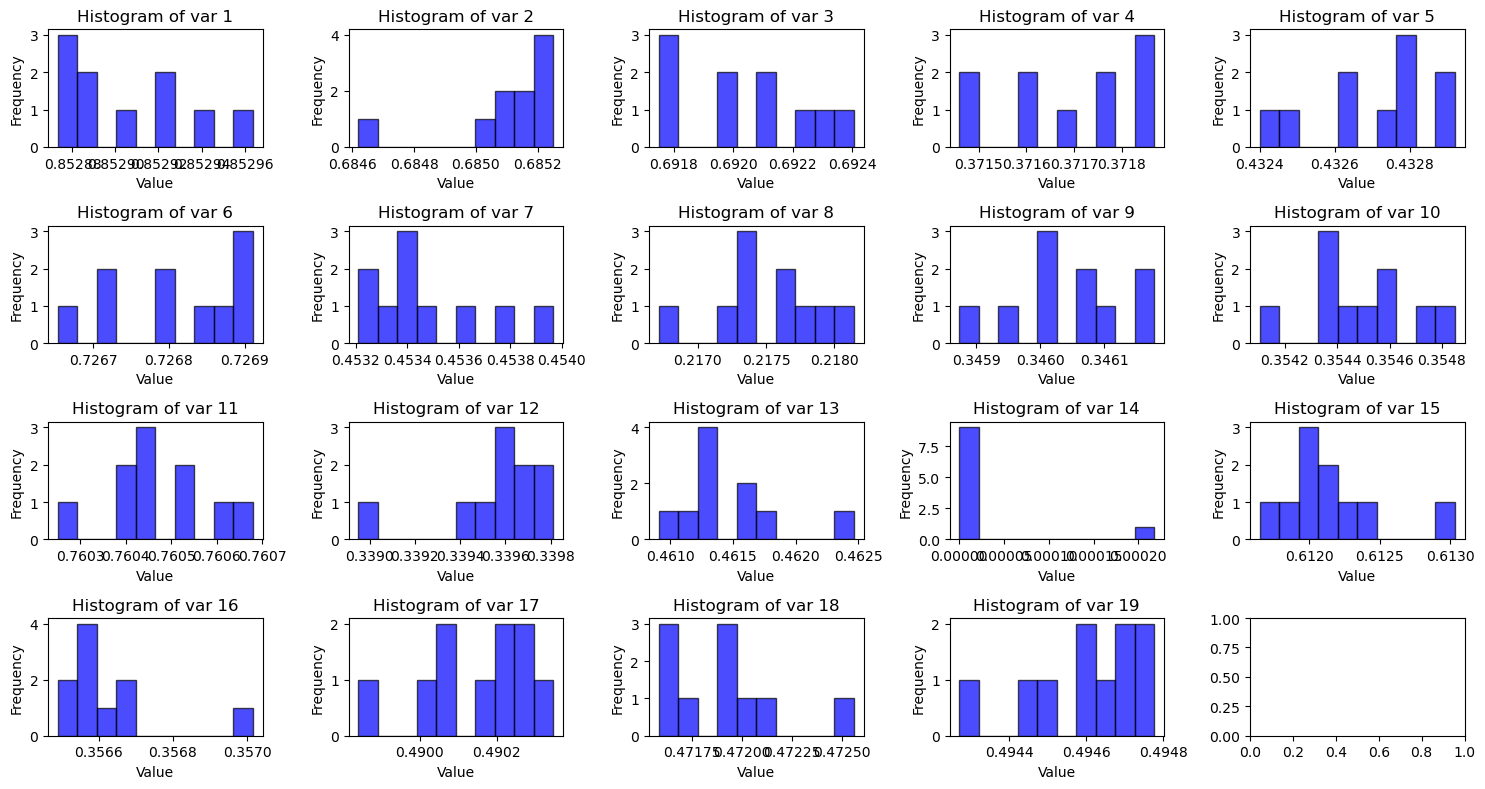

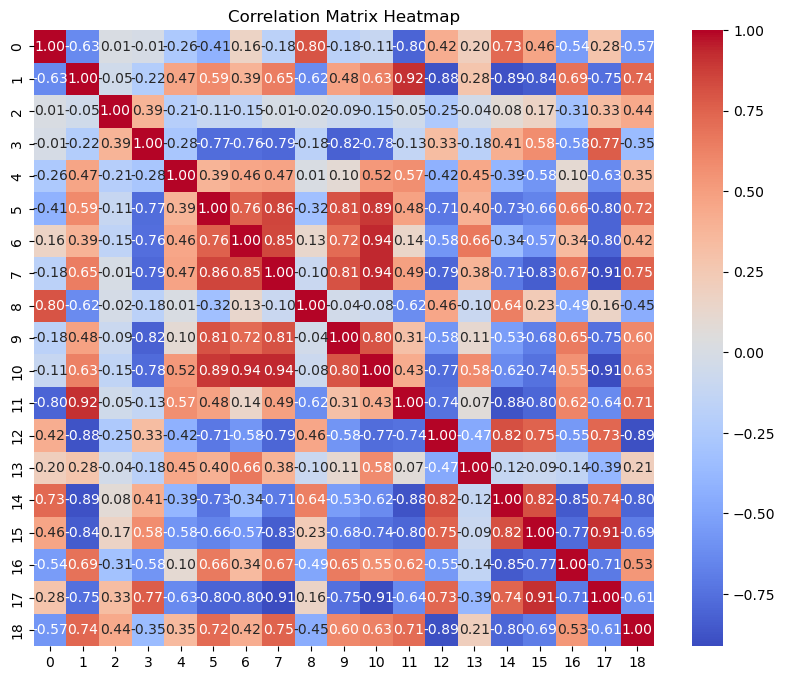

In [7]:
print(np.shape(x_top_10_candidates))
# Create subplots for the 8 histograms
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily iterate
# Plot each histogram
for i in range(19):
    axes[i].hist((x_top_10_candidates[:, i]), bins=10, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Histogram of var {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
# Adjust layout
plt.tight_layout()
plt.show()

# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [12]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

Launch Pymapdl
     Launch Pymapdl successfully, duration 6.5797 seconds.


### Objecttive function for comparison with expirmental data

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  True
     Element size                  :  0.4
     Height of building            :  3.2759217146731126
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 7.4945 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04489553582640332
     Excitation node               :  5770
Using Modal-superpostion method
     /SOLU finished, duration 28.7129 seconds.
 Extract all modal information , duration 4.4478 seconds.
 /POS

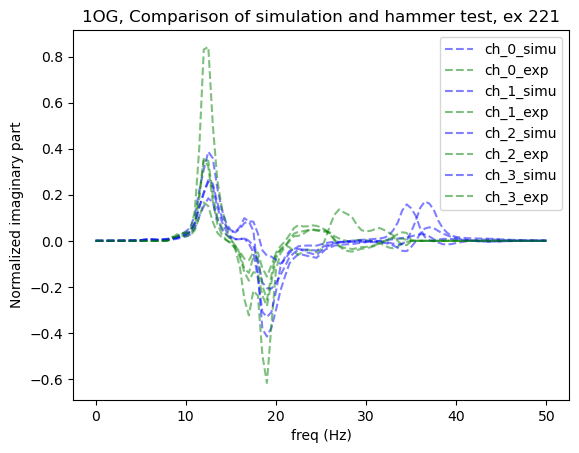

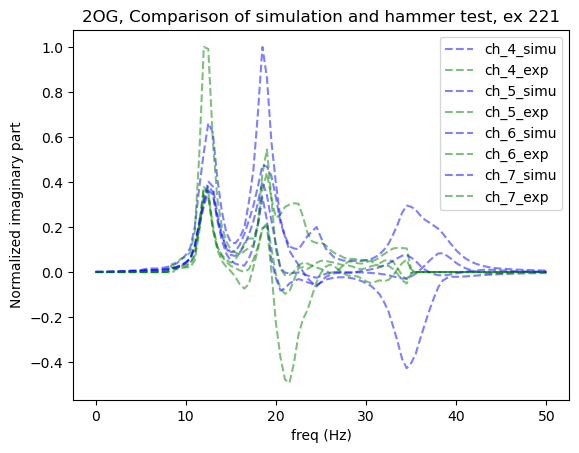

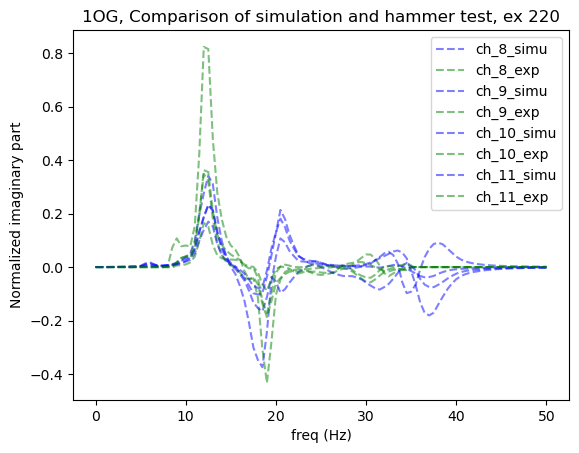

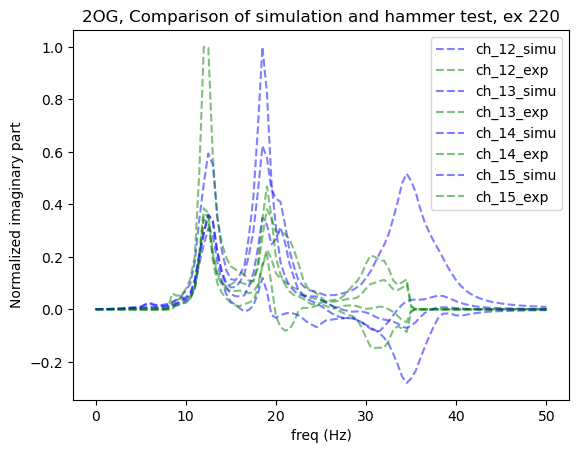

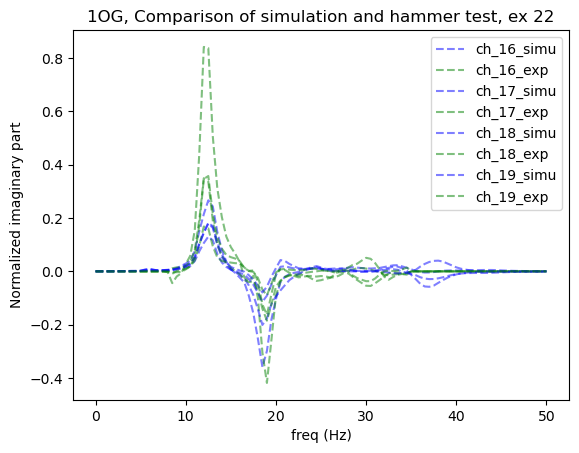

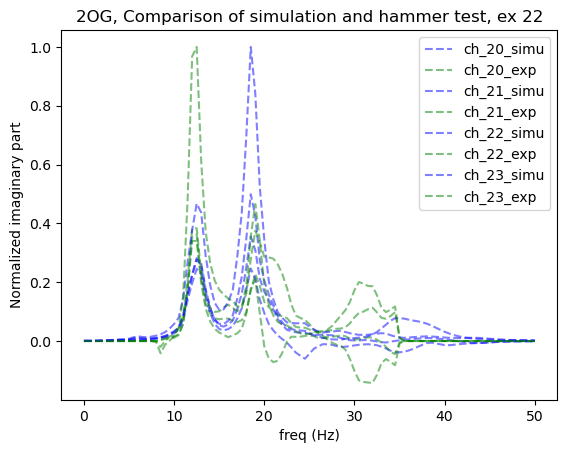

19.133643757227375
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  True
     Element size                  :  0.4
     Height of building            :  3.2757858142147516
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.6297 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.044893123148490297
     Excitation node               :  5770
Using Modal-superpostion method
     /SOLU finished, duration 28.7098 seconds.
 Extract all modal information , duration 3

KeyboardInterrupt: Interrupted during MAPDL execution

In [9]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    #
    for i in range(0,4):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

    print(error_percentage)

    return error_percentage



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1

freq_resample = np.linspace(0, 50, 101)
for i_top_para in range(np.shape(x_top_10_candidates)[0]):
    error_per = objective_function(x_top_10_candidates[i_top_para,:])
#    channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
#    channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]
#
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
    



### Using GP for further optimization

#### Objective function

In [13]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    X_input = np.array(X_input)
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    return error_percentage

### GP optimization

Best objective value: 17.83919977706634
Best parameters:
x1: 0.9173
x2: 0.4558
x3: 0.8706
x4: 0.6217
x5: 0.5614
x6: 0.7433
x7: 0.2035
x8: 0.2559
x9: 0.2239
x10: 0.2206
x11: 0.7609
x12: 0.2141
x13: 0.4770
x14: 0.0494
x15: 0.4989
x16: 0.4636
x17: 0.5583
x18: 0.7219
x19: 0.2446
[0.9173055877685943, 0.4558246815052984, 0.8705829617358014, 0.621693681209637, 0.5613661418841733, 0.7433335018712679, 0.20349517135542816, 0.2559406103336736, 0.22391872538758234, 0.22058042708760567, 0.7609137040102073, 0.21407146612180028, 0.4770378833122931, 0.04941301747784355, 0.4989189248374976, 0.4635588199248357, 0.5583394068425642, 0.7219010058577093, 0.24460051333729088]


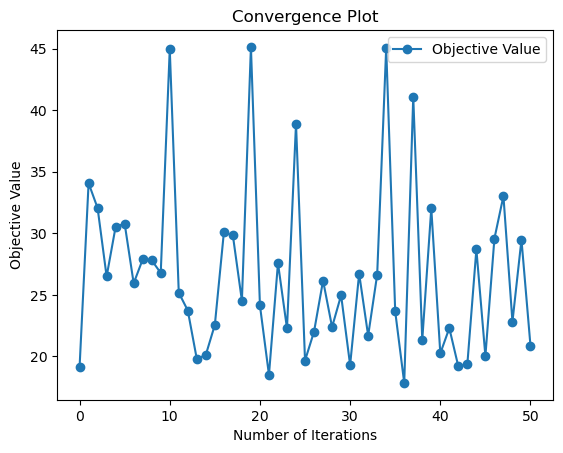

In [14]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Initial guess
initial_points = np.mean(x_top_10_candidates, axis=0)
# Create bounds by adding/subtracting 0.5 and clamping to [0, 1]
bound = [(max(0, val - 0.25), min(1, val + 0.25)) for val in initial_points]
# Convert to skopt's Real dimensions for optimization
bounds = [Real(low, high, name=f"x{i}") for i, (low, high) in enumerate(bound)]
# Evaluate the objective function at these initial points
initial_values = objective_function(initial_points) 

# Convert the objective function to use named arguments
@use_named_args(bounds)
def wrapped_objective(**params):
    return objective_function(list(params.values()))

# Run Gaussian Process Optimization
result = gp_minimize(
    func=wrapped_objective,
    dimensions=bounds,
    n_calls=50,  # Total evaluations, including initial points
    x0=initial_points.tolist(),
    y0=[initial_values],
    random_state=42
)

# Display the results
print("Best objective value:", result.fun)
print("Best parameters:")
for i, param in enumerate(result.x):
    print(f"x{i+1}: {param:.4f}")
print(result.x)

# Visualize progress of the optimization
import matplotlib.pyplot as plt
plt.plot(result.func_vals, marker='o', label="Objective Value")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()


### Validation from L-BFGS-B

In [15]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_oriignal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

x_best = result.x
x_best = np.array(x_best)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




[0.6632990150757021, 0.7646597452042387, 0.06852914808679007, 0.2243387362419274, 0.21227322837683468, 0.6632990150757021]
[24866670037.425358, 14069903427.108562, 15118812206.673473, 14478374507.751648, 14411608541.752113, 24866670037.425358]
[2900.1015192234768, 1642.3643720801406, 2247.187131618274, 1263.6499401990402, 2297.5135271262443, 2900.1015192234768]
[337.2455869736925, 1481.67516957959, 0.33]
4.117806389740481
0.03989201026674582


### Visualization

### Excitation 221, compare to exp 9

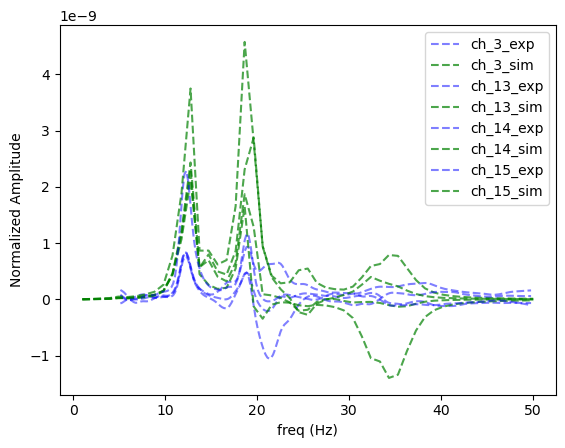

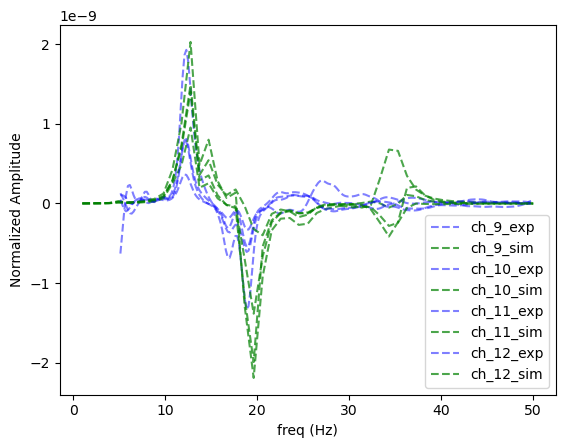

[12.4474821 12.4474821 12.4474821 12.4474821 12.4474821 12.4474821
 12.4474821 12.4474821]
12.4474821 19.170604566666665 0.7333092238744306 0.5831207121191299


In [16]:
i_file = 9
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []


for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex221
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
i_ch_disp = [9,10,11,12,3,13,14,15]

mode_freq_1_list = np.zeros(len(i_ch_disp))
mode_freq_2_list = np.zeros(len(i_ch_disp))
mac_1_list = np.zeros(len(i_ch_disp))
mac_2_list = np.zeros(len(i_ch_disp))
#
#
for i_ch in range(len(i_ch_disp)):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)
print(mode_freq_1_list)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

### Excitation 220, compare to exp 1

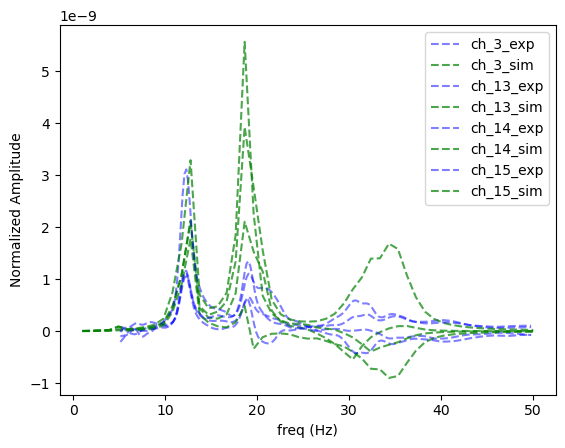

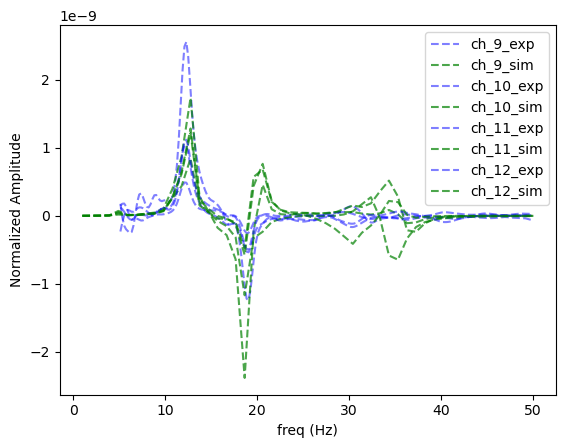

12.4474821 19.11582741428571 0.7287120594310318 0.565301851258544


In [17]:
i_file = 1
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex220
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs_e = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

Exictation 22, compare to exp 13

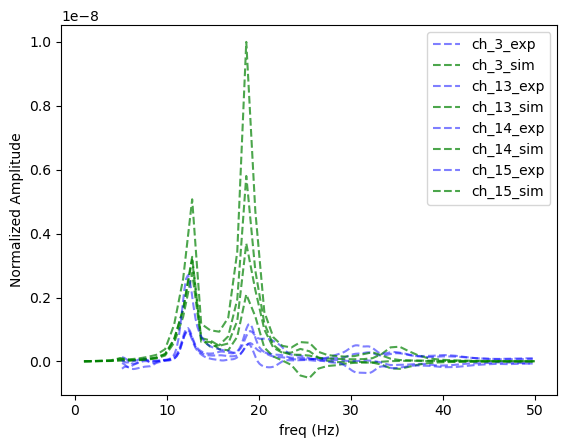

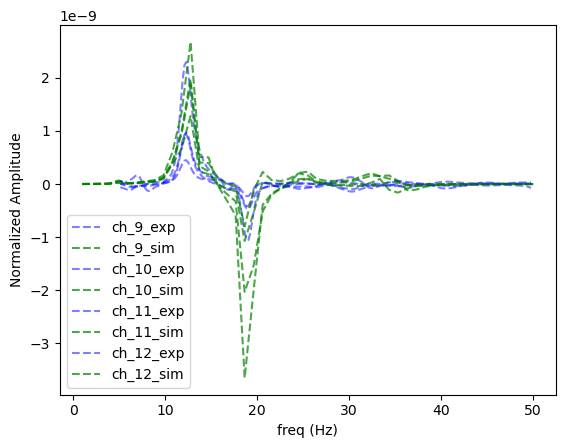

12.4474821 18.7871645 0.6160523020339247 0.6313607029682916


In [18]:
i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex22
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )